# Create masks for high EKE regions and others

In [1]:
%reload_ext autoreload
%autoreload 2

import xarray as xr

import sys 
sys.path.append("../")

import plot_utils
import utils
from utils import region_dic

### Open *all-sat* EKE temporal mean and define high EKE regions with 90th percentile

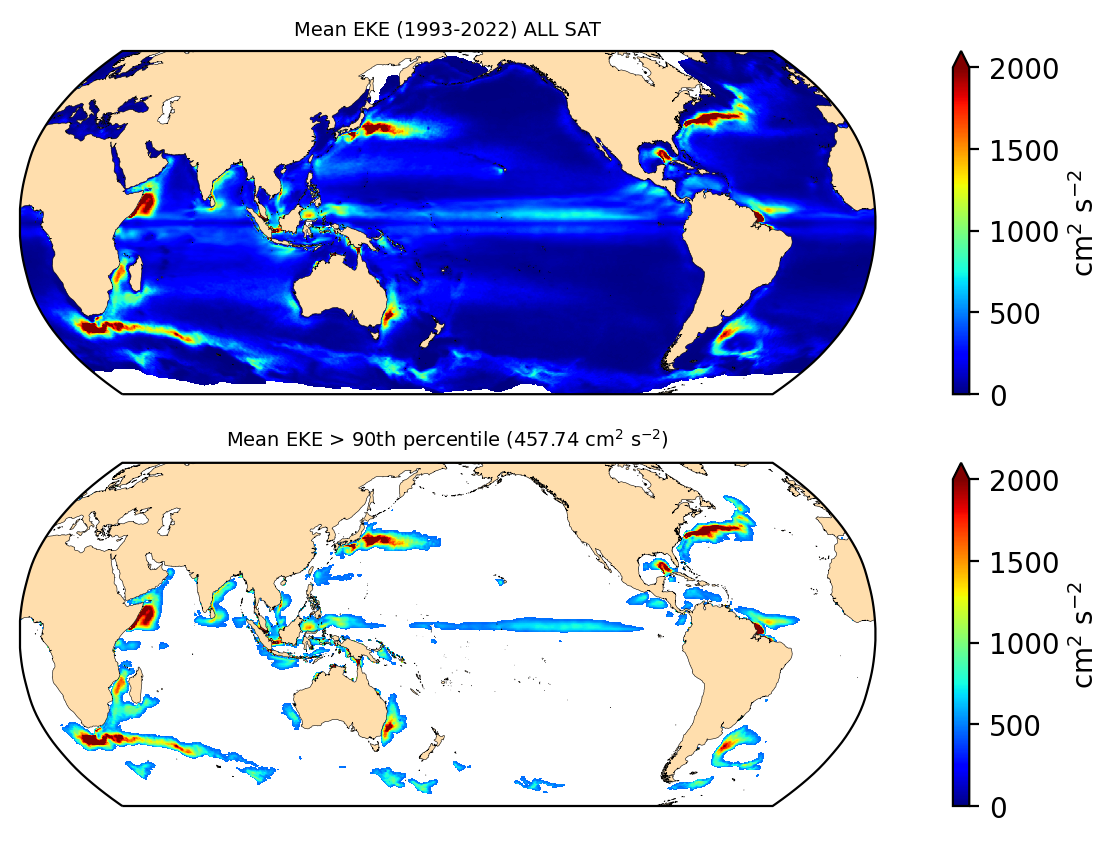

In [2]:
# Open EKE temporal mean (for all-sat)
path    = '../../results/EKE_ALL_SAT/tmean/EKE_ALL_SAT_tmean.nc'
ds      = xr.open_dataset(path)
eke     = ds['EKE']

# Define high EKE regions
threshold = eke.quantile(0.90)
high_eke  = eke.where(eke > threshold)


# Plot EKE temporal mean and high EKE regions
titles = ['Mean EKE (1993-2022) ALL SAT',
          'Mean EKE > 90th percentile (' + "{:.2f}".format(threshold.data) +' cm$^2$ s$^{{-2}}$)']

plot_utils.map_plot([eke, high_eke],
           vmax=2000,
           cmap='jet',
           label='cm$^2$ s$^{-2}$',
           titles=titles)

###  Testing that defining individual high EKE regions works

This test doesn't work for the Loop Current (LC) because of the lim used in the smoothing. Solved later.

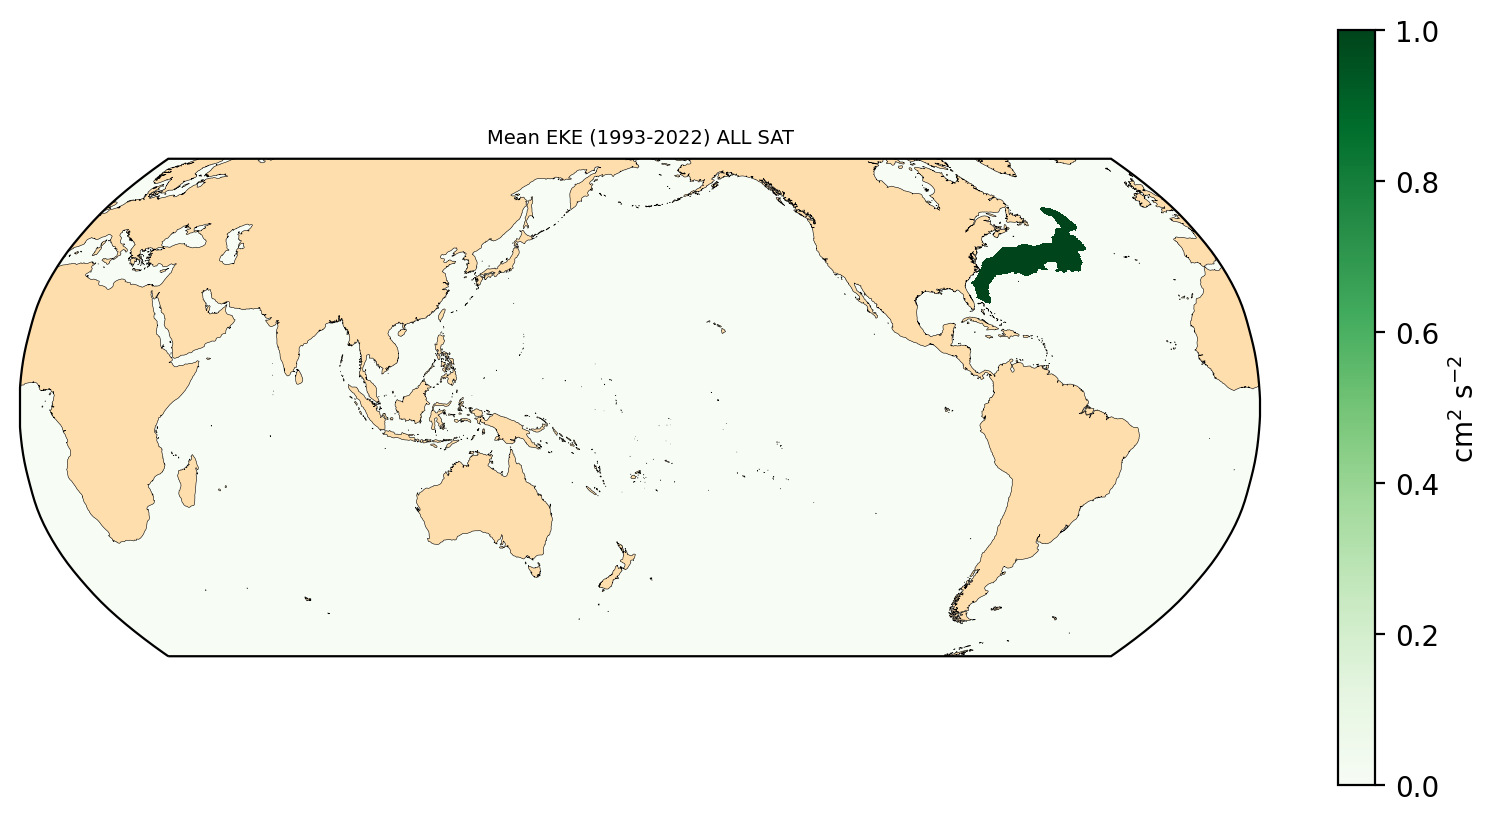

In [3]:
# Test a region

region      = 'GS' # Gulf Stream
coords      = region_dic[region]

eke_reg = utils.crop(high_eke, coords)
eke_reg = eke_reg.where(eke_reg.isnull(), 1)
eke_reg = eke_reg.where(eke_reg.notnull(), 0)
eke_reg = utils.smooth_regions(eke_reg, lim=1000) # this lim value makes the LC disappear

plot_utils.map_plot([eke_reg],
           vmax=1,
           cmap='Greens',
           label='cm$^2$ s$^{-2}$',
           titles=titles)

### Create the dataset with the masks of all individual high EKE regions (defined in region_dic) 

In [4]:
masks = xr.Dataset(coords={'lat': ds.lat, 'lon': ds.lon})

for region in region_dic:

    coords  = region_dic[region]
    eke_reg = utils.crop(high_eke, coords)
    eke_reg = eke_reg.where(eke_reg.isnull(), 1)
    eke_reg = eke_reg.where(eke_reg.notnull(), 0)
    lim = 1000
    if region == 'LC':
        lim = 100

    eke_reg = utils.smooth_regions(eke_reg, lim=lim)
    masks[region] = eke_reg

In [5]:
#for region in region_dic: 
    
#    plot_utils.map_plot([masks[region]],
#           vmax=1,
#           cmap='Greens',
#           label='cm$^2$ s$^{-2}$',
#           titles=region)

### Create and add additional masks: all high EKE regions combined, tropical, no ice (global), remainder (residual)

a) Create a mask for all high EKE regions combined.

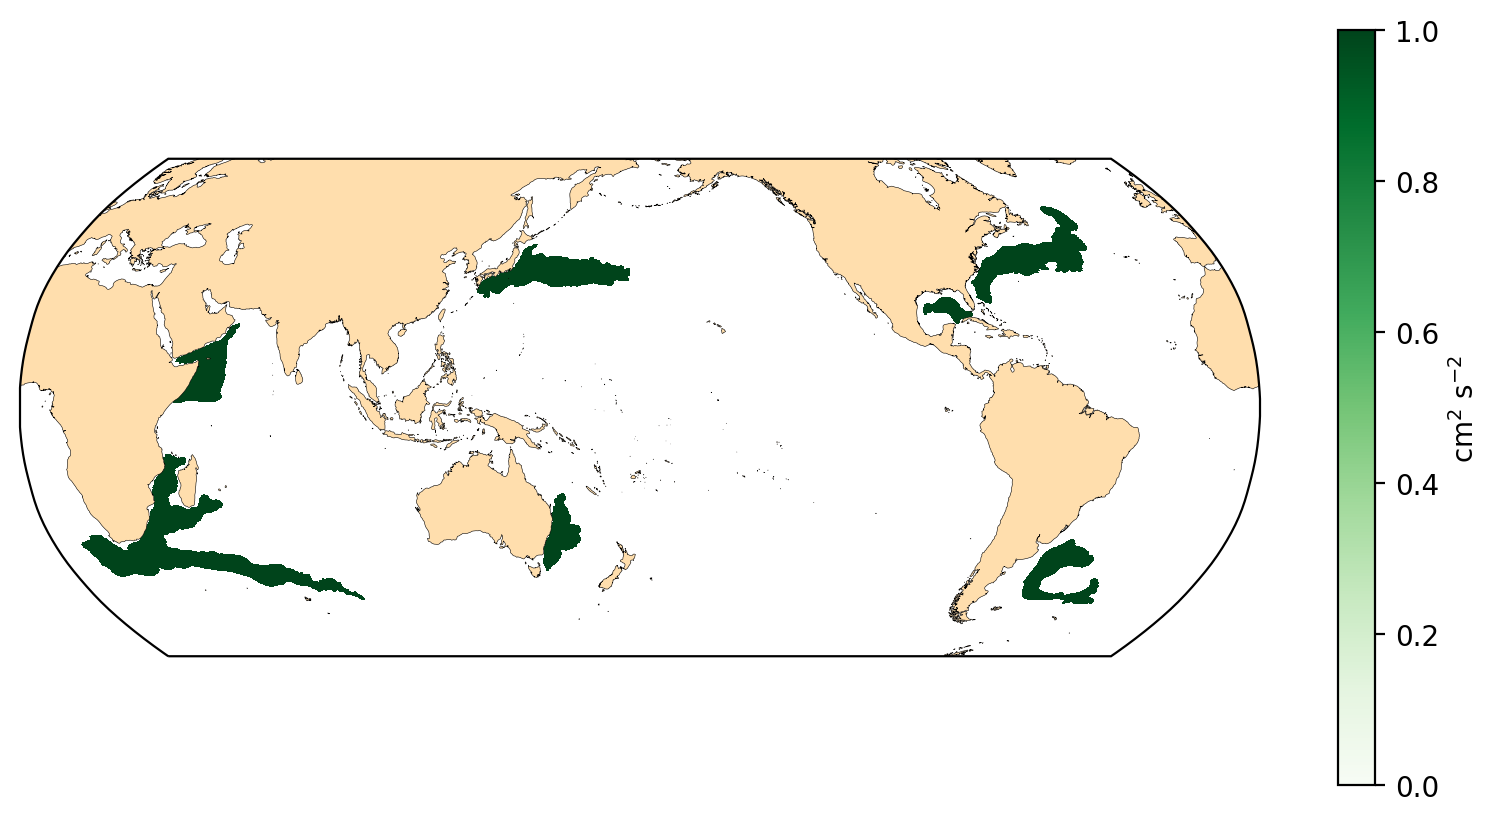

In [6]:
all_regs          = [masks[reg].where(masks[reg].notnull(), 0) for reg in region_dic]
masks['high eke'] = sum(all_regs)
masks['high eke'] = masks['high eke'].where(masks['high eke'] == 1)

# check
plot_utils.map_plot([masks['high eke']],
           vmax=1,
           cmap='Greens',
           label='cm$^2$ s$^{-2}$')


b) Create a mask for the tropical region.

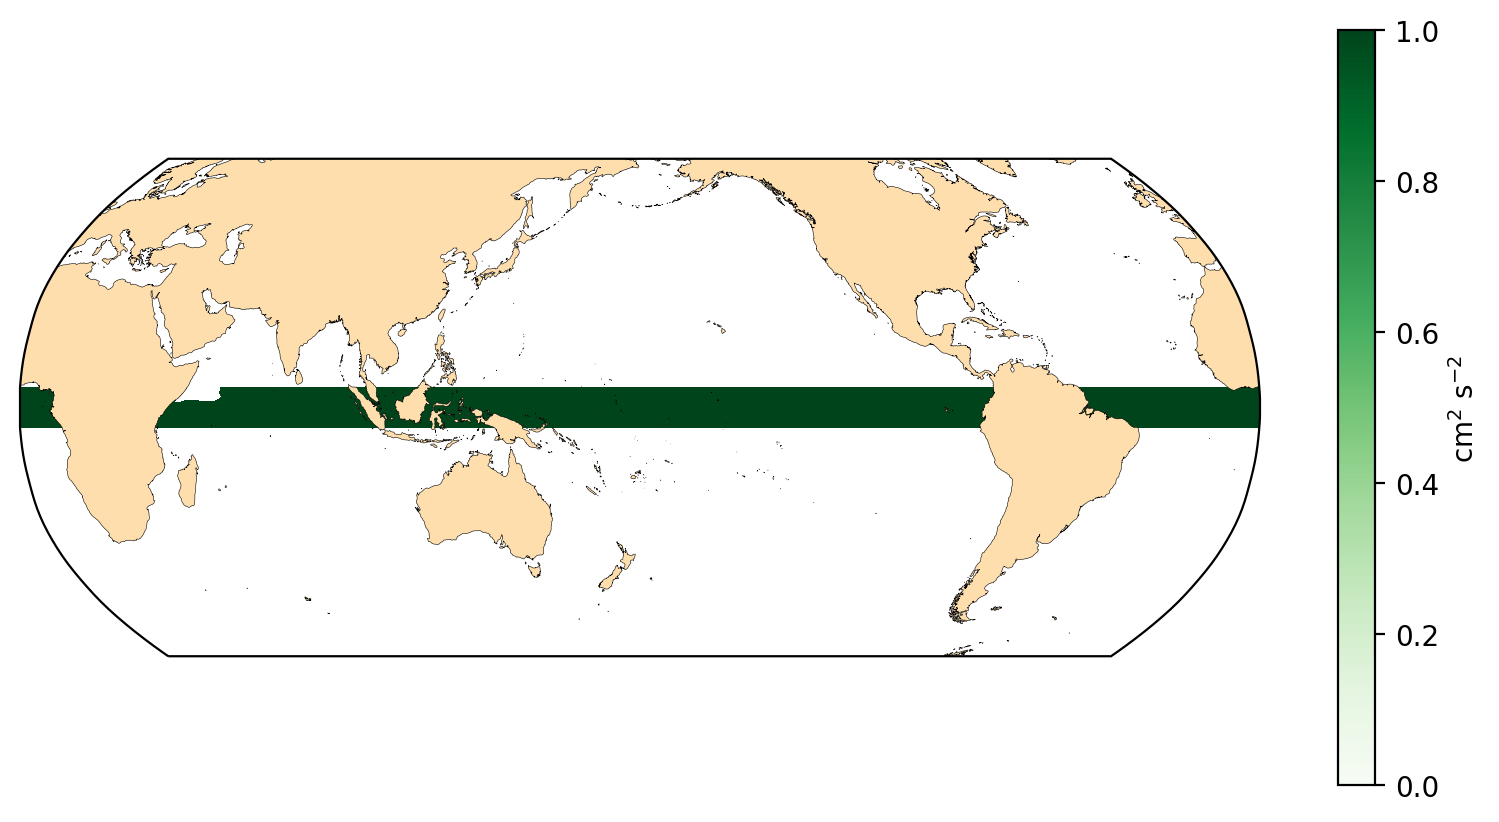

In [7]:
masks['tropical'] = high_eke.where(abs(high_eke.lat)>5, 1)
masks['tropical'] = masks['tropical'].where(masks['tropical'] == 1)
# Remove the high EKE regions from the tropical mask
masks['tropical'] = masks['tropical'].where(masks['high eke'] != 1)

# check
plot_utils.map_plot([masks['tropical']],
           vmax=1,
           cmap='Greens',
           label='cm$^2$ s$^{-2}$')

c) Create a global mask.

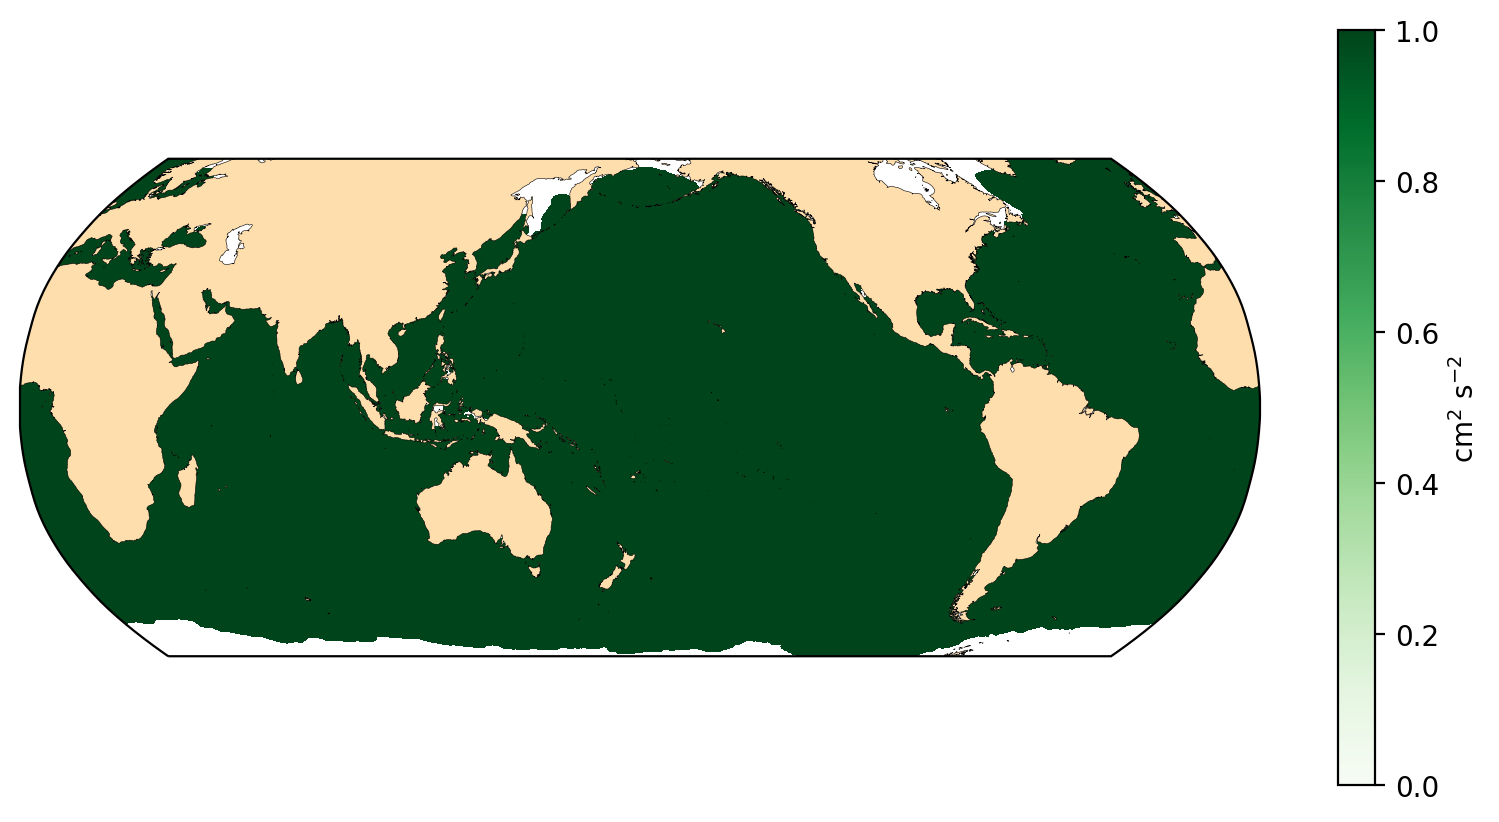

In [8]:
masks['no ice'] = eke.where(eke.isnull(), 1)

# check
plot_utils.map_plot([masks['no ice']],
           vmax=1,
           cmap='Greens',
           label='cm$^2$ s$^{-2}$')

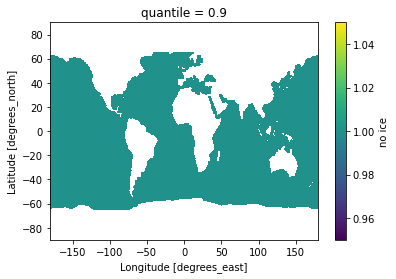

In [9]:
masks['no ice'].plot.pcolormesh(ylim=[-90, 90])

d) Create the residual mask (global but excluding high EKE regions and tropical band).

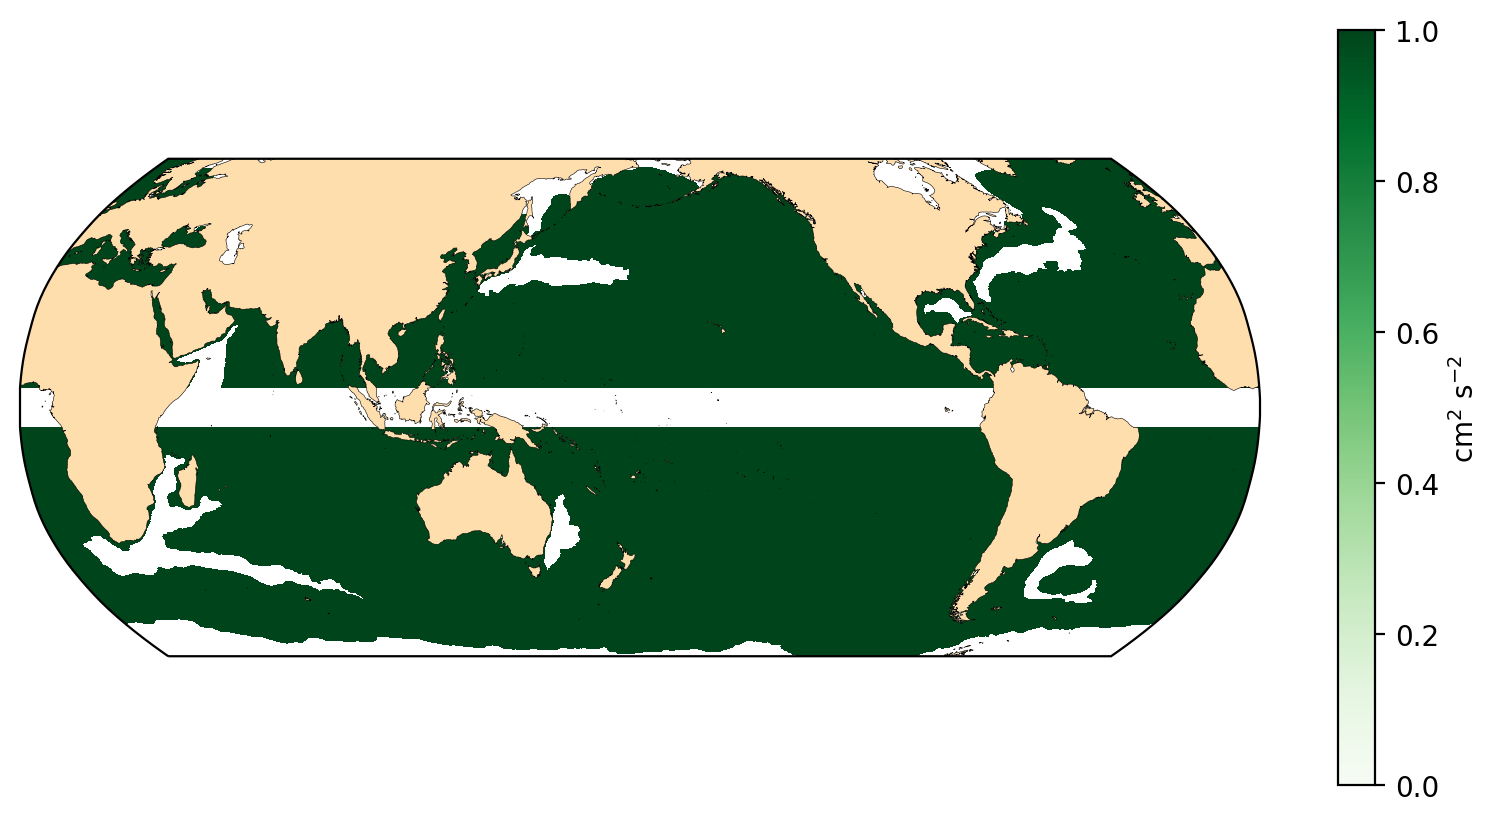

In [10]:
masks['remainder'] = eke.where(masks['no ice'].notnull())
masks['remainder'] = masks['remainder'].where(masks['tropical']!=1)
masks['remainder'] = masks['remainder'].where(masks['high eke']!=1)
masks['remainder'] = masks['remainder'].where(masks['remainder'].isnull(), 1)

# check
plot_utils.map_plot([masks['remainder']],
           vmax=1,
           cmap='Greens',
           label='cm$^2$ s$^{-2}$')

e) Others

In [11]:
masks = masks.drop('quantile')
masks.attrs['title'] = "Masks"

### Save the masks to a netcdf file

In [13]:

comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in masks.data_vars}

masks.to_netcdf('../../results/masks.nc',
              encoding=encoding)